# Recall study II

In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=2.0)

#### Git machinery

In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = '5273391d742b9de04a97883c9765403b38ecfe03'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

In [3]:
from network import BCPNNFast, NetworkManager
from plotting_functions import plot_winning_pattern
from analysis_functions import calculate_recall_success, calculate_timings
from connectivity_functions import artificial_connectivity_matrix
from analysis_functions import calculate_recall_success_sequences
from connectivity_functions import create_artificial_manager, calculate_random_sequence

## How many sequences can we generate?

In [4]:
# Patterns parameters
hypercolumns = 4
minicolumns = 25
n_patterns = 10

dt = 0.001

value = 1.0
inhibition = -1
decay_factor = 0.9
sequence_decay = 0.9
extension = 2

sequence_length = 4
overload = 3
overlap = 3
one_to_one = True

# Desired patterns
total_sequences = 5000

# Running parameters
max_iter = 1e4

# Random seed
prng = np.random.RandomState(seed=2)
prng = np.random

In [5]:
overload_range = np.arange(1, minicolumns, 1)
overlap_range = np.arange(0, minicolumns - 1, 1)
n_sequences_mean = np.zeros((overload_range.size, overlap_range.size))
n_sequences_var = np.zeros((overload_range.size, overlap_range.size))
n_calculations = 20


for index_overload, overload in enumerate(overload_range):
    print(index_overload)
    for index_overlap, overlap in enumerate(overlap_range):
        n_list = []
        for i in range(n_calculations):
            aux = calculate_random_sequence(minicolumns, sequence_length, overlap,  overload,  one_to_one=one_to_one,
                                            prng=prng, total_sequences=total_sequences, max_iter=max_iter)

            sequences, overlap_dictionary, overload_matrix = aux
            n_sequences = len(sequences)
            n_list.append(n_sequences)

        n_sequences_mean[index_overload, index_overlap] = np.mean(n_list)
        n_sequences_var[index_overload, index_overlap] = np.var(n_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


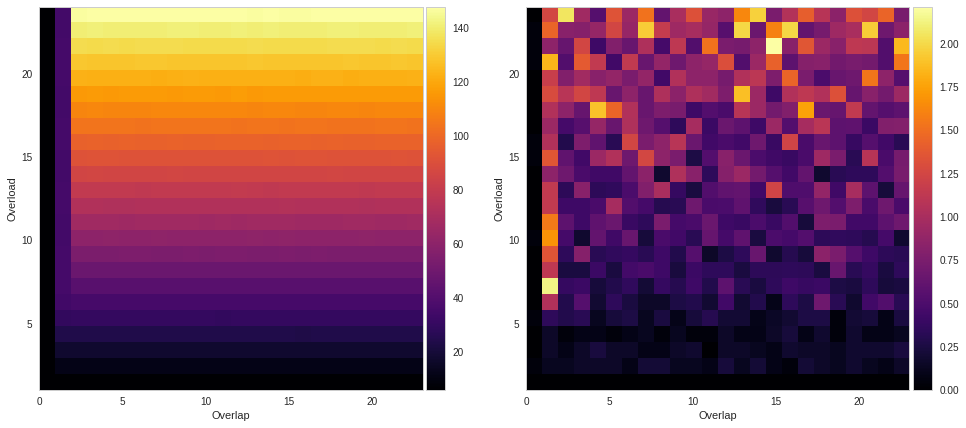

In [6]:
sns.set_style("whitegrid", {'axes.grid': False})
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

extent = [overlap_range[0], overlap_range[-1], overload_range[0], overload_range[-1]]

cmap = 'inferno'
im1 = ax1.imshow(n_sequences_mean, origin='lower', cmap=cmap, interpolation='None', extent=extent)
im2 = ax2.imshow(n_sequences_var, origin='lower', cmap=cmap, interpolation='None', extent=extent)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')

ax1.set_xlabel('Overlap')
ax1.set_ylabel('Overload')
ax2.set_xlabel('Overlap')
ax2.set_ylabel('Overload');

## Calculate capacity

In [19]:
# Patterns parameters
hypercolumns = 4
minicolumns = 30
n_patterns = 10

dt = 0.001

value = 1.0
inhibition = -1
decay_factor = 0.9
sequence_decay = 0.9
extension = 2

sequence_length = 10
one_to_one = True

# Desired patterns
total_sequences = 25

# Running parameters
max_iter = 1e4

# Random seed
prng = np.random.RandomState(seed=2)
prng = np.random

overload_range = np.arange(1, sequence_length, 1)
overlap_range = np.arange(0, sequence_length - 1, 1)
recall_success_mean = np.zeros((overload_range.size, overlap_range.size))
recall_success_var = np.zeros((overload_range.size, overlap_range.size))

n = 10
T_cue = 0.100
T_recall = 2.0

In [20]:
for index_overload, overload in enumerate(overload_range):
    print(index_overload)
    for index_overlap, overlap in enumerate(overlap_range):

        aux = calculate_random_sequence(minicolumns, sequence_length, overlap,  overload,  one_to_one=one_to_one,
                                        prng=prng, total_sequences=total_sequences, max_iter=max_iter)

        sequences, overlap_dictionary, overload_matrix = aux

        manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value, inhibition, extension,
                                            decay_factor,
                                            sequence_decay, dt, BCPNNFast, NetworkManager)

        # Recall
        successes = calculate_recall_success_sequences(manager, T_recall, T_cue, n, sequences)
        
        
        mean = np.mean(successes)
        recall_success_mean[index_overload, index_overlap] = mean 
        recall_success_var[index_overload, index_overlap] = np.var(successes) * mean


0
1
2
3
4
5
6
7
8


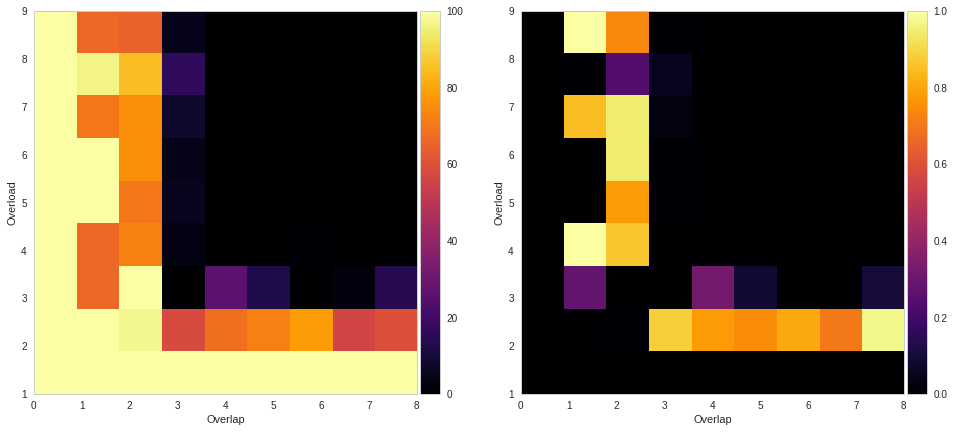

In [21]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

extent = [overlap_range[0], overlap_range[-1], overload_range[0], overload_range[-1]]

cmap = 'inferno'
im1 = ax1.imshow(recall_success_mean, origin='lower', cmap=cmap, interpolation='None', extent=extent)
im2 = ax2.imshow(recall_success_var / recall_success_var.max(), origin='lower', cmap=cmap, interpolation='None', extent=extent)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')

ax1.set_xlabel('Overlap')
ax1.set_ylabel('Overload')
ax2.set_xlabel('Overlap')
ax2.set_ylabel('Overload');

# Another calculation of capacity
This time I count the possible number of sequences that you could have before the recall rate falling to zero. The results are not very good. 

In [10]:
# Patterns parameters
hypercolumns = 4
minicolumns = 10
n_patterns = 10

dt = 0.001

value = 1.0
inhibition = -1
decay_factor = 0.9
sequence_decay = 0.9
extension = 1

sequence_length = 5
overload = 3
overlap = 2
one_to_one = True

# Desired patterns
total_sequences = 10

# Running parameters
max_iter = 1e4

# Random seed
prng = np.random.RandomState(seed=2)
# prng = np.random

overload_range = np.arange(1, minicolumns, 1)
overlap_range = np.arange(0, minicolumns - 1, 1)
recall_success_mean = np.zeros((overload_range.size, overlap_range.size))
recall_success_var = np.zeros((overload_range.size, overlap_range.size))

n = 1
T_cue = 0.100
T_recall = 2.0


In [11]:
aux = calculate_random_sequence(minicolumns, sequence_length, overlap,  overload,  one_to_one=one_to_one,
                                prng=prng, total_sequences=total_sequences, max_iter=max_iter)
sequences, overlap_dictionary, overload_matrix = aux
3
n_sequences_total = len(sequences)
capacity = []
weighted_var = []

for n_sequences in range(1, n_sequences_total):
    print(n_sequences)

    partial_sequences = sequences[:n_sequences]
    print(partial_sequences)
    manager = create_artificial_manager(hypercolumns, minicolumns, partial_sequences, value, inhibition, extension,
                                    decay_factor,
                                    sequence_decay, dt, BCPNNFast, NetworkManager)

    # Recall
    successes = calculate_recall_success_sequences(manager, T_recall, T_cue, n, partial_sequences)
    print(successes)

    mean = np.mean(successes)
    capacity.append(mean)
    weighted_var.append(mean * np.var(successes))


1
[[4, 1, 5, 0, 7]]
[100.0]
2
[[4, 1, 5, 0, 7], [1, 6, 0, 2, 3]]
[0.0, 100.0]
3
[[4, 1, 5, 0, 7], [1, 6, 0, 2, 3], [5, 9, 8, 0, 2]]
[0.0, 100.0, 0.0]


#### Git machinery

In [ ]:
if run_old_version:
    subprocess.call(['git', 'checkout', 'master'])